Pseudo Code:
```py
function LlamaAttentionWithABC_forward(
    hidden_states, 
    position_embeddings, 
    attention_mask, 
    checkpoint_positions, 
    budget
):

    # Step 1: Identify checkpoint tokens
    is_checkpoint = zeros(seq_len, dtype=bool)
    is_checkpoint[checkpoint_positions] = true

    # Step 2: Compute budget-aware checkpoint embeddings
    remaining_budget = budget - checkpoint_positions
    checkpoint_emb = checkpoint_embedding  # Shared <C>
    for pos, rem in zip(checkpoint_positions, remaining_budget):
        checkpoint_emb[pos] = rotate(checkpoint_emb, rem, theta)  # RoPE-inspired rotation

    # Step 3: Inject checkpoint embeddings into hidden_states
    hidden_states = where(is_checkpoint, checkpoint_emb, hidden_states)

    # Step 4: Project to queries, keys, values
    query = q_proj(hidden_states).reshape(bsz, num_heads, seq_len, head_dim)
    key = k_proj(hidden_states).reshape(bsz, num_kv_heads, seq_len, head_dim)
    value = v_proj(hidden_states).reshape(bsz, num_kv_heads, seq_len, head_dim)

    # Step 5: Apply standard RoPE to all tokens
    query, key = apply_rotary_pos_emb(query, key, cos, sin)

    # Step 6: Modify attention mask for ABC
    if attention_mask is not null:
        checkpoint_mask = is_checkpoint.unsqueeze(0) & is_checkpoint.unsqueeze(1)
        attention_mask = mask_fill(attention_mask, checkpoint_mask, -inf)  # Checkpoints only attend to checkpoints

    # Step 7: Compute attention
    attn_output, attn_weights = attention_interface(query, key, value, attention_mask, scaling)

    # Step 8: Project back and return
    attn_output = o_proj(attn_output.reshape(bsz, seq_len, hidden_size))
    return attn_output, attn_weights
```

In [1]:
import random
from functools import lru_cache, partial

import torch
import torch.nn.functional as F

from tabulate import tabulate
from torch.nn.attention.flex_attention import (
    _DEFAULT_SPARSE_BLOCK_SIZE,
    create_block_mask,
    create_mask,
    flex_attention,
)
from triton.testing import do_bench

torch.set_default_device("cuda:1")
torch.manual_seed(0)

torch._dynamo.config.cache_size_limit = 1000

# Compile the flex_attention function
flex_attention = torch.compile(flex_attention, dynamic=False)
compiled_flex_attention = torch.compile(flex_attention)

# For better performance, you can use:
# flex_attention = torch.compile(_flex_attention, dynamic=False, mode="max-autotune-no-cudagraphs")

data_type = torch.float16

# The kernels will utilize block sparisty to increase performance
print(f"Using the default sparsity block size: {_DEFAULT_SPARSE_BLOCK_SIZE}")

Using the default sparsity block size: 128


In [2]:
@lru_cache
def create_block_mask_cached(score_mod, B, H, M, N, device="cuda"):
    block_mask = create_block_mask(score_mod, B, H, M, N, device=device)
    return block_mask


def calculate_tflops(flops: float, time_ms: float, multiplier: int) -> float:
    return multiplier * flops * (1e3 / time_ms) / 1e12


def test_mask(
    score_mod=None,
    mask_mod=None,
    B=16,
    H=16,
    S=8192,
    D=64,
    skip_correctness=False,
    print_mask=True,
    device="cuda"
):
    assert (
        score_mod is not None or mask_mod is not None
    ), "Must provide a score_mod or mask_mod"
    query = torch.randn(
        B, H, S, D, device=device, dtype=torch.float16, requires_grad=True
    )
    key = torch.randn(
        B, H, S, D, device=device, dtype=torch.float16, requires_grad=True
    )
    value = torch.randn(
        B, H, S, D, device=device, dtype=torch.float16, requires_grad=True
    )
    gradOut = torch.randn(B, H, S, D, device=device, dtype=torch.float16)

    if mask_mod is not None:
        block_mask = create_block_mask_cached(mask_mod, 1, 1, S, S, device=query.device)
    else:
        block_mask = None
    sdpa_mask_fn = mask_mod if mask_mod is not None else score_mod
    mask = create_mask(sdpa_mask_fn, 1, 1, S, S, device=query.device)

    causal_fa2 = lambda: F.scaled_dot_product_attention(
        query, key, value, is_causal=True
    )
    xformers_mask = lambda: F.scaled_dot_product_attention(
        query, key, value, attn_mask=mask
    )
    flex_attention_call = lambda: flex_attention(
        query, key, value, score_mod=score_mod, block_mask=block_mask
    )

    results = []
    if block_mask is not None:
        density = (100 - block_mask.sparsity()) / 100
    else:
        density = 1.0
    causal_fav2_flops = 0.5 * B * H * D * S * S
    flops = density * B * H * D * S * S

    # Forward pass
    causal_fa2_time = do_bench(causal_fa2)
    xformers_mask_time = do_bench(xformers_mask)
    flex_ms = do_bench(flex_attention_call)

    # Backward pass
    causal_fa2_out = causal_fa2()
    xformers_out = xformers_mask()
    flex_out = flex_attention_call()

    causal_fa2_bw_time = do_bench(
        lambda: causal_fa2_out.backward(gradOut, retain_graph=True)
    )
    xformers_mask_bw_time = do_bench(
        lambda: xformers_out.backward(gradOut, retain_graph=True)
    )
    flex_bw_ms = do_bench(lambda: flex_out.backward(gradOut, retain_graph=True))

    # Inline correctness check
    if not skip_correctness:
        xformers_outs = []
        flex_outs = []

        query.grad = None
        key.grad = None
        value.grad = None

        out1 = xformers_mask()
        xformers_outs.append(out1)
        out1.backward(gradOut)
        xformers_outs += [query.grad, key.grad, value.grad]

        query.grad = None
        key.grad = None
        value.grad = None

        out2 = flex_attention_call()
        flex_outs.append(out2)
        out2.backward(gradOut)
        flex_outs += [query.grad, key.grad, value.grad]
        for flex, xformer in zip(flex_outs, xformers_outs):
            torch.testing.assert_close(flex, xformer, atol=1e-1, rtol=1e-2)

        print("Correctness check passed ✅")
    # Usage in your results formatting:
    results = [
        [
            "causal FA2",
            f"{causal_fa2_time:.4f}",
            f"{calculate_tflops(causal_fav2_flops, causal_fa2_time, 4):.2f}",
            f"{causal_fa2_bw_time:.4f}",
            f"{calculate_tflops(causal_fav2_flops, causal_fa2_bw_time, 10):.2f}",
        ],
        [
            "F.sdpa + mask",
            f"{xformers_mask_time:.4f}",
            f"{calculate_tflops(flops, xformers_mask_time, 4):.2f}",
            f"{xformers_mask_bw_time:.4f}",
            f"{calculate_tflops(flops, xformers_mask_bw_time, 10):.2f}",
        ],
        [
            "flexattention",
            f"{flex_ms:.4f}",
            f"{calculate_tflops(flops, flex_ms, 4):.2f}",
            f"{flex_bw_ms:.4f}",
            f"{calculate_tflops(flops, flex_bw_ms, 10):.2f}",
        ],
    ]
    print(
        f"\nResults for {score_mod.__name__ if score_mod is not None else mask_mod.__name__}:"
    )
    print(
        tabulate(
            results,
            headers=[
                "Operation",
                "FW Time (ms)",
                "FW FLOPS (TF/s)",
                "BW Time (ms)",
                "BW FLOPS (TF/s)",
            ],
            tablefmt="grid",
        )
    )
    if print_mask:
        print(f"\nBlock Mask:\n{block_mask}")

    # Clean up to save memory
    del query, key, value, gradOut, causal_fa2_out, xformers_out, flex_out
    torch.cuda.empty_cache()

In [3]:
def test_flexattention(
    score_mod=None,
    mask_mod=None,
    B=4,
    H=8,
    S=1024,
    D=64,
    device="cuda"
):

    assert score_mod is not None or mask_mod is not None, "Must provide score_mod or mask_mod"
    
    # Create minimal tensors
    query = torch.randn(B, H, S, D, device=device, dtype=torch.float16, requires_grad=True)
    key = torch.randn(B, H, S, D, device=device, dtype=torch.float16, requires_grad=True)
    value = torch.randn(B, H, S, D, device=device, dtype=torch.float16, requires_grad=True)
    gradOut = torch.randn(B, H, S, D, device=device, dtype=torch.float16)
    
    # Create block_mask if needed
    block_mask = None
    if mask_mod is not None:
        block_mask = create_block_mask_cached(mask_mod, 1, 1, S, S, device=device)
    
    try:
        # Forward pass
        out = flex_attention(query, key, value, score_mod=score_mod, block_mask=block_mask)
        
        # Backward pass
        out.backward(gradOut)
        
        print("✓ Flexattention validation successful - both forward and backward passes completed")
        
        # Clean up
        del query, key, value, gradOut, out
        torch.cuda.empty_cache()
        
        return True, block_mask
        
    except Exception as e:
        print(f"✗ Flexattention validation failed with error: {e}")
        return False, block_mask

In [4]:
import torch
from IPython.display import Image, display

"""PRINT CHECK FOR ABC MASK.
    print("checkpoints:", checkpoints)
    print("cp_tensor:", cp_tensor)
    print("q_idx:", q_idx)
    print("kv_idx:", kv_idx)
    zero_tensor = torch.zeros_like(cp_q_block, dtype=torch.bool, device=device)
    one_tensor = torch.ones_like(cp_kv_block, dtype=torch.bool, device=device)
"""

def _checkpoint_ids_to_tensor(checkpoints, seq_len, device="cpu"):
    assert isinstance(checkpoints, list)
    tensor = torch.zeros(seq_len, dtype=torch.bool, device=device)
    tensor[checkpoints] = True
    return tensor

def generate_abc(cp_tensor):
    
    def abc(b, h, q_idx, kv_idx):
        cp_q_block = cp_tensor[q_idx]
        cp_kv_block = cp_tensor[kv_idx]

        causal = (q_idx >= kv_idx)
        q_checkpoints = (cp_q_block == False)
        kv_checkpoints = (cp_kv_block == True)

        return causal & q_checkpoints | kv_checkpoints
        
    abc_mask = abc
    abc_mask.__name__ = f"abc"
    return abc_mask

def main(device: str = "cpu"):
    """Visualize the attention scores of sliding window mask mod.

    Args:
        device (str): Device to use for computation. Defaults
    """
    from attn_gym import visualize_attention_scores

    B, H, SEQ_LEN, HEAD_DIM = 1, 1, 100, 8

    def make_tensor():
        return torch.ones(B, H, SEQ_LEN, HEAD_DIM, device=device)

    query, key = make_tensor(), make_tensor()

    checkpoints=[32, 48, 60]
    cp_tensor = _checkpoint_ids_to_tensor(
        checkpoints=checkpoints, 
        seq_len=SEQ_LEN, 
        device=device
    )
    
    abc_mask = generate_abc(
        cp_tensor=cp_tensor
    )
    
    IMAGE_NAME = "abc_mask"
    visualize_attention_scores(
        query, key, mask_mod=abc_mask, device=device, name=IMAGE_NAME
    )
    display(Image(f"{IMAGE_NAME}.png", width=800, height=800))

Visualization saved as abc_mask.png


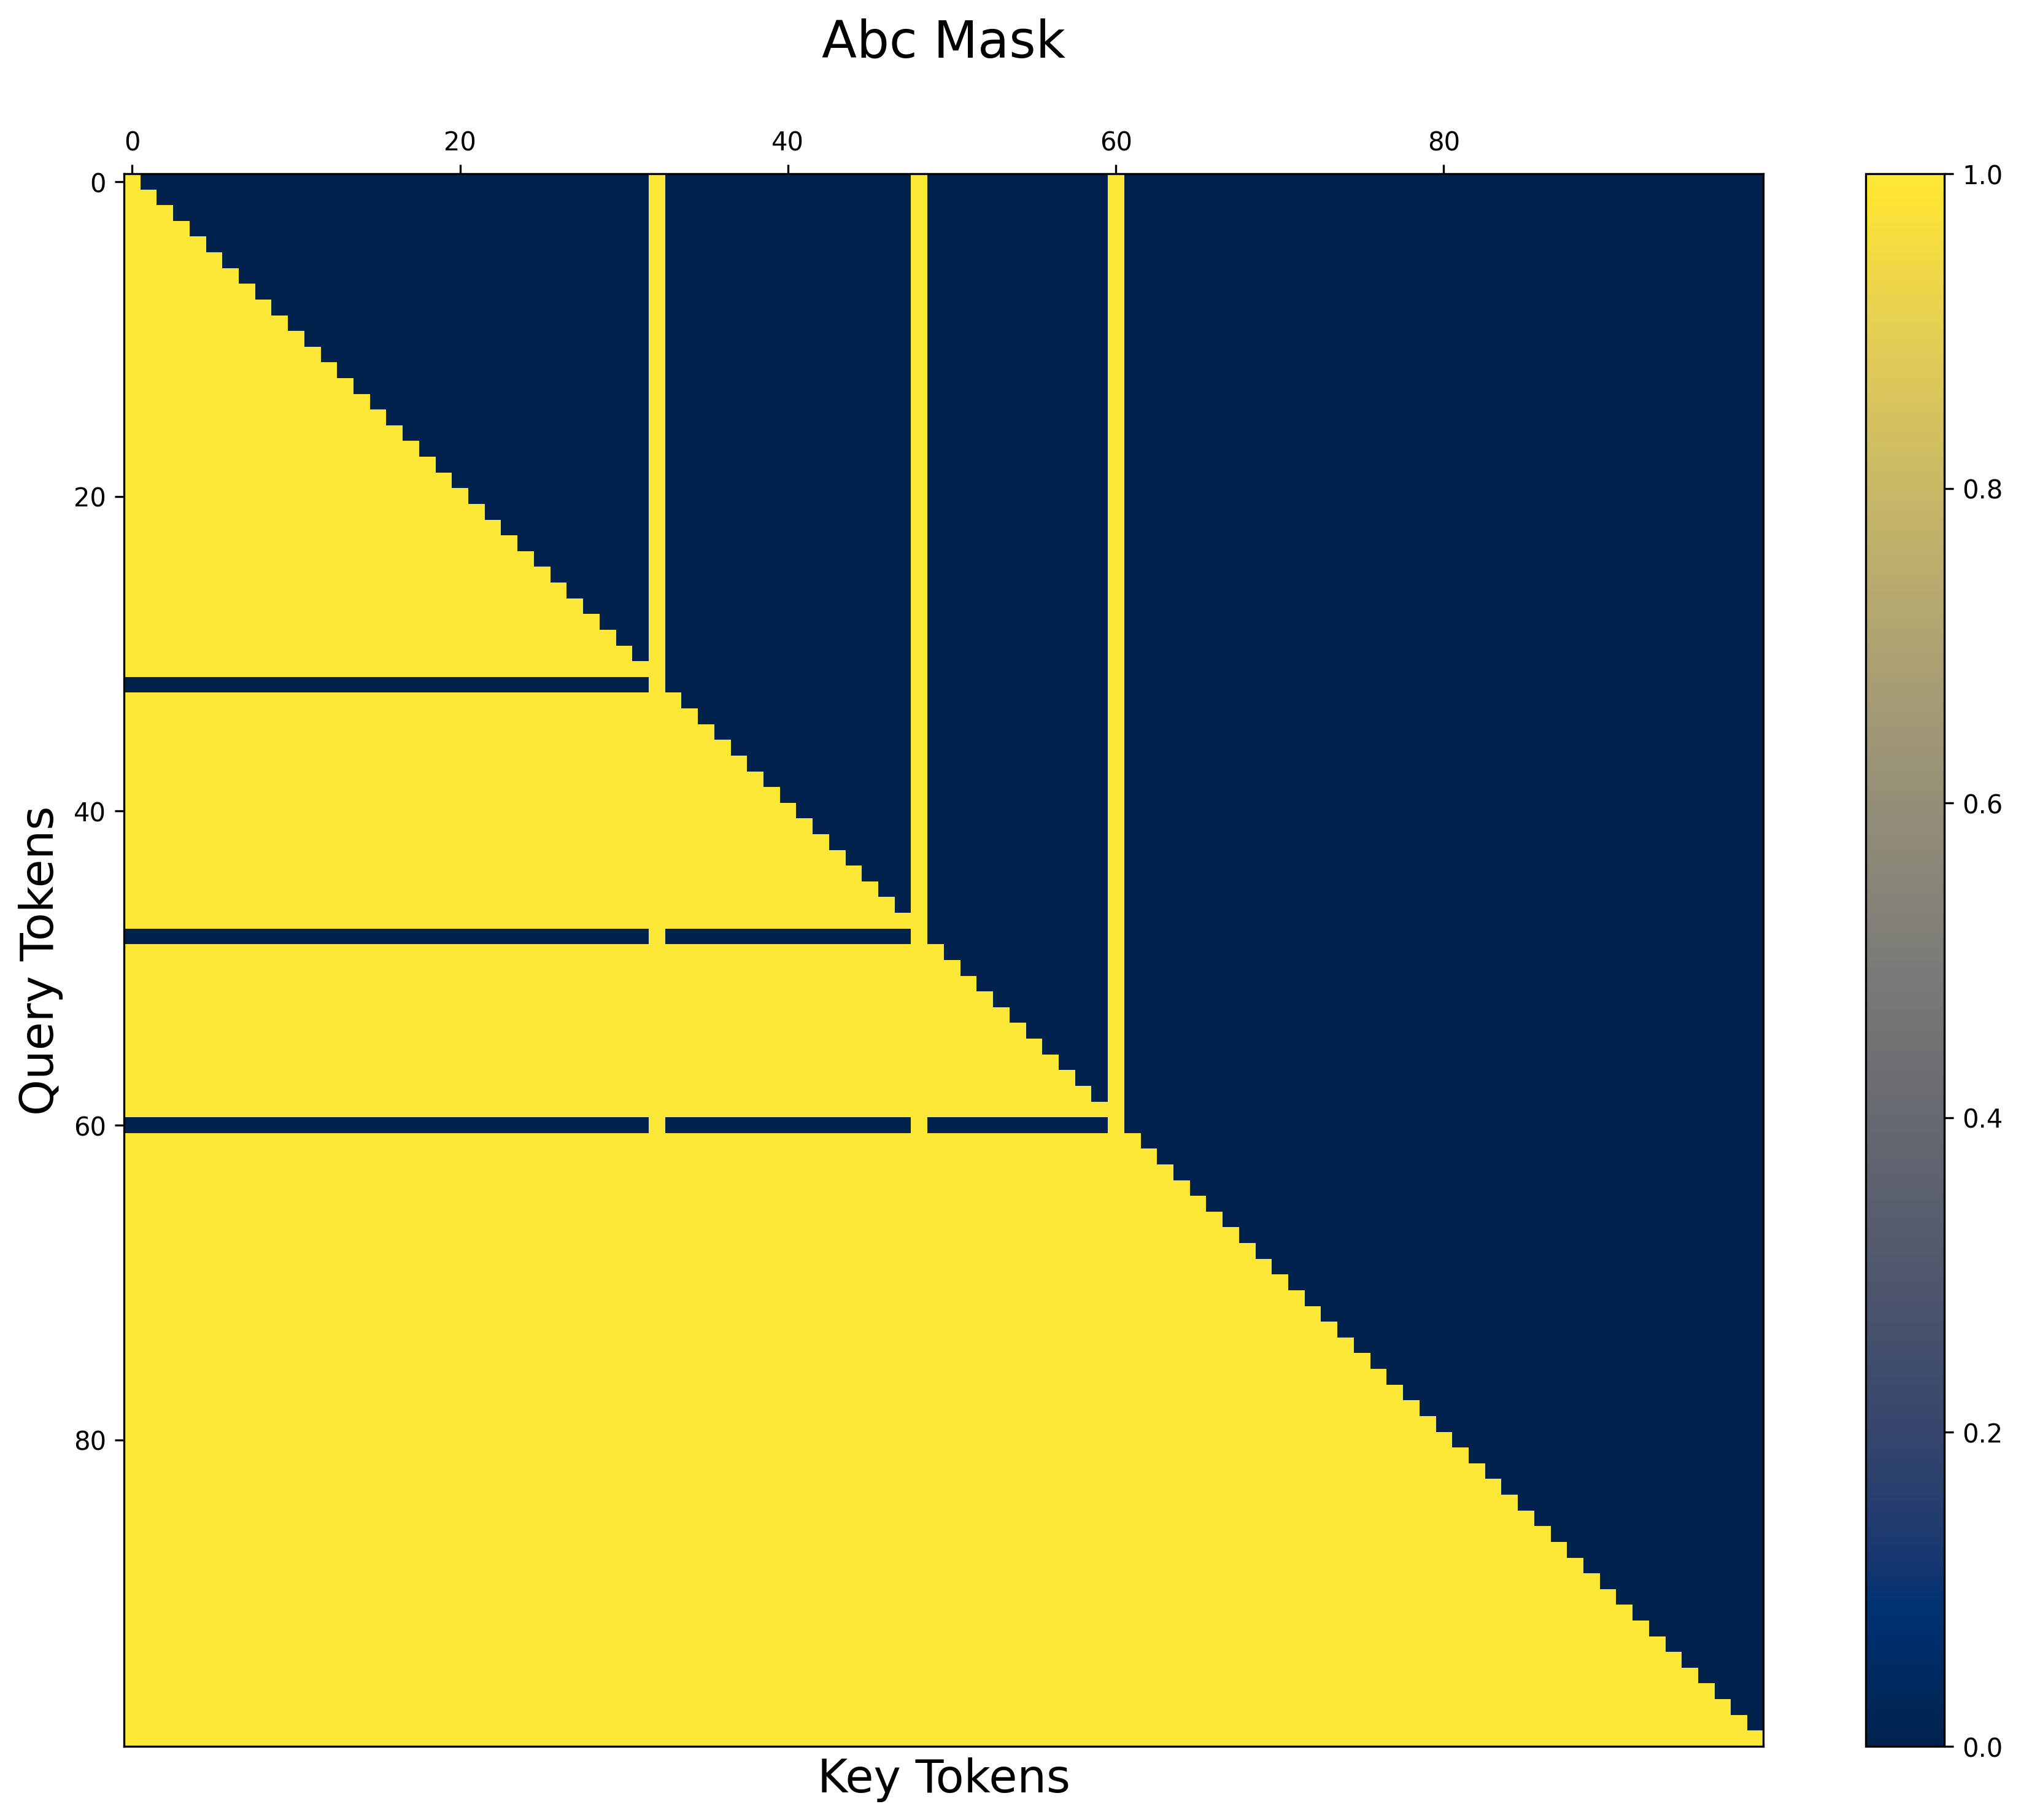

In [7]:
main()

In [9]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx
B, H, SEQ_LEN, HEAD_DIM = 16, 8, 2048, 64
test_mask(
    mask_mod=causal_mask,
    B=B,
    H=H,
    S=SEQ_LEN,
    D=HEAD_DIM,
    print_mask=True,
    # device=device
)

Correctness check passed ✅

Results for causal_mask:
+---------------+----------------+-------------------+----------------+-------------------+
| Operation     |   FW Time (ms) |   FW FLOPS (TF/s) |   BW Time (ms) |   BW FLOPS (TF/s) |
+===============+================+===================+================+===================+
| causal FA2    |         1.2074 |             56.92 |         3.6197 |             47.46 |
+---------------+----------------+-------------------+----------------+-------------------+
| F.sdpa + mask |         3.2065 |             22.77 |        12.2141 |             14.94 |
+---------------+----------------+-------------------+----------------+-------------------+
| flexattention |         1.1492 |             63.53 |         4.0637 |             44.92 |
+---------------+----------------+-------------------+----------------+-------------------+

Block Mask:
BlockMask(shape=(1, 1, 2048, 2048), sparsity=46.88%, 
(0, 0)
██                              
████        

In [5]:
B, H, SEQ_LEN, HEAD_DIM = 16, 8, 256, 64
device="cuda"
BASE_IDX, STEP = 0, 4
checkpoints=[BASE_IDX + i * STEP for i in range(3)]
cp_tensor = _checkpoint_ids_to_tensor(
    checkpoints=checkpoints, 
    seq_len=SEQ_LEN, 
    device=device
)

abc_mask = generate_abc(
    cp_tensor=cp_tensor
)
    
test_mask(
    mask_mod=abc_mask,
    B=B,
    H=H,
    S=SEQ_LEN,
    D=HEAD_DIM,
    print_mask=True,
    # device=device
)

Correctness check passed ✅

Results for abc:
+---------------+----------------+-------------------+----------------+-------------------+
| Operation     |   FW Time (ms) |   FW FLOPS (TF/s) |   BW Time (ms) |   BW FLOPS (TF/s) |
+===============+================+===================+================+===================+
| causal FA2    |         0.0517 |             20.77 |         0.2125 |             12.63 |
+---------------+----------------+-------------------+----------------+-------------------+
| F.sdpa + mask |         0.07   |             22.99 |         0.3119 |             12.91 |
+---------------+----------------+-------------------+----------------+-------------------+
| flexattention |         0.0766 |             21.04 |         0.3187 |             12.63 |
+---------------+----------------+-------------------+----------------+-------------------+

Block Mask:
BlockMask(shape=(1, 1, 256, 256), sparsity=25.00%, 
(0, 0)
██  
████
)


In [6]:
create_mask(abc_mask, 1, 1, SEQ_LEN, SEQ_LEN, device="cuda")

tensor([[[[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True, False, False],
          [ True,  True,  True,  ...,  True,  True, False],
          [ True,  True,  True,  ...,  True,  True,  True]]]], device='cuda:0')

In [7]:
create_mask??

Signature:
create_mask(
    mod_fn: Union[Callable[[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor], Callable[[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor]],
    B: Optional[int],
    H: Optional[int],
    Q_LEN: int,
    KV_LEN: int,
    device: str = 'cuda',
    _compile: bool = False,
) -> torch.Tensor
Source:   
def create_mask(
    mod_fn: Union[_score_mod_signature, _mask_mod_signature],
    B: Optional[int],
    H: Optional[int],
    Q_LEN: int,
    KV_LEN: int,
    device: str = "cuda",
    _compile: bool = False,
) -> Tensor:
    r"""This function creates a mask tensor from a mod_fn function.

    Args:
        mod_fn (Union[_score_mod_signature, _mask_mod_signature]): Function to modify attention scores.
        B (int): Batch size.
        H (int): Number of query heads.
        Q_LEN (int): Sequence length of query.
        KV_LEN (int): Sequence length of key/value.
        device (str): Device to run the mask 

In [8]:
abc_mask = generate_abc(
    cp_tensor=cp_tensor
)

def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx
    
test_mask(
    mask_mod=abc_mask,
    B=B,
    H=H,
    S=SEQ_LEN,
    D=HEAD_DIM,
    print_mask=True,
    device=device
)

ValueError: Pointer argument (at 3) cannot be accessed from Triton (cpu tensor?)

In [18]:
_, block_mask = test_flexattention(
    mask_mod=abc_mask,
    B=B,
    H=H,
    S=SEQ_LEN,
    D=HEAD_DIM,
    device=device
)

✗ Flexattention validation failed with error: Pointer argument (at 3) cannot be accessed from Triton (cpu tensor?)


In [75]:
print(block_mask[0,0])

BlockMask(shape=(1024, 1024), sparsity=34.38%, 
()
████████        
████████        
████████        
████████        
██████████      
████████████    
██████████████  
████████████████
)


In [80]:
B, H, SEQ_LEN, HEAD_DIM = 1, 1, 1024, 64
def make_tensor():
    return torch.ones(B, H, SEQ_LEN, HEAD_DIM, device=device)
device="cuda:1"
query, key, value = make_tensor(), make_tensor(), make_tensor()
abc_mask = generate_abc(
    checkpoints=[100, 300, 500],
    seq_len=SEQ_LEN,
    device=device
)

block_mask = create_block_mask(
    abc_mask, B, H, SEQ_LEN, SEQ_LEN, 
    BLOCK_SIZE=(64, 64),
    device=device
)
flex_attention(query, key, value, block_mask=block_mask)
# flex_attention(query, key, value, score_mod=abc_mask)

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]],
       device='cuda:1')

In [81]:
print(block_mask)

BlockMask(shape=(1, 1, 2048, 2048), sparsity=42.19%, 
(0, 0)
████    ██    ██                
████    ██    ██                
██████  ██    ██                
██████████    ██                
██████████    ██                
████████████  ██                
████████████████                
████████████████                
██████████████████              
████████████████████            
██████████████████████          
████████████████████████        
██████████████████████████      
████████████████████████████    
██████████████████████████████  
████████████████████████████████
)


In [ ]:
import torch.nn as nn

class LlamaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config, layer_idx):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.scaling = self.head_dim**-0.5
        self.attention_dropout = config.attention_dropout
        self.is_causal = True

        self.q_proj = nn.Linear(
            config.hidden_size, config.num_attention_heads * self.head_dim, bias=config.attention_bias
        )
        self.k_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.v_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.o_proj = nn.Linear(
            config.num_attention_heads * self.head_dim, config.hidden_size, bias=config.attention_bias
        )

    def forward(
        self,
        hidden_states,
        position_embeddings,
        attention_mask=None,
        past_key_value=None,
        cache_position=None,
        **kwargs
    ):
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_value is not None:
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        attention_interface = eager_attention_forward
        if self.config._attn_implementation != "eager":
            if not (self.config._attn_implementation == "sdpa" and kwargs.get("output_attentions", False)):
                attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        attn_output, attn_weights = attention_interface(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            **kwargs,
        )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output, attn_weights

In [4]:
import torch.nn as nn

class LlamaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config, layer_idx):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.scaling = self.head_dim**-0.5
        self.attention_dropout = config.attention_dropout
        self.is_causal = True

        self.q_proj = nn.Linear(
            config.hidden_size, config.num_attention_heads * self.head_dim, bias=config.attention_bias
        )
        self.k_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.v_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.o_proj = nn.Linear(
            config.num_attention_heads * self.head_dim, config.hidden_size, bias=config.attention_bias
        )

    def forward(
        self,
        hidden_states,
        position_embeddings,
        attention_mask=None,
        past_key_value=None,
        cache_position=None,
        **kwargs
    ):
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_value is not None:
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        attention_interface = eager_attention_forward
        if self.config._attn_implementation != "eager":
            if not (self.config._attn_implementation == "sdpa" and kwargs.get("output_attentions", False)):
                attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        attn_output, attn_weights = attention_interface(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            **kwargs,
        )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output, attn_weights